<a href="https://colab.research.google.com/github/sebcalcagno/AnalisisSeriesTemporales/blob/main/CLASE_7/AST_Clase_7_ejercicio_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

LSTM es una forma de redes neuronales recurrentes que es una de las redes más utilizadas con el fin de pronosticar series de tiempo porque funciona muy bien cuando la secuencia de los datos es muy importante

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/sebcalcagno/AnalisisSeriesTemporales/main/produccion_leche.csv',index_col='Date',parse_dates=True)
df.index.freq='MS'

In [ ]:
df.head()

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


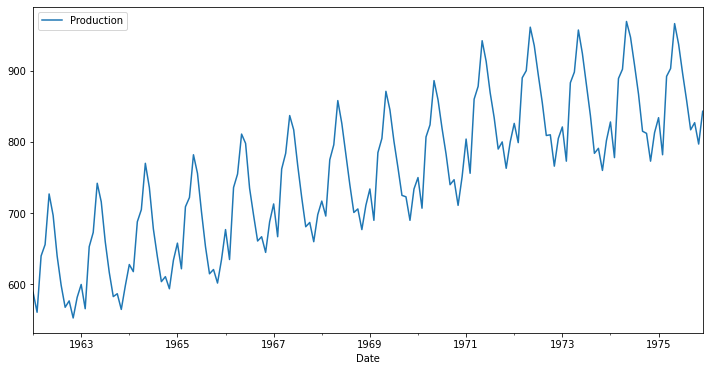

In [ ]:
df.plot(figsize=(12,6))

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


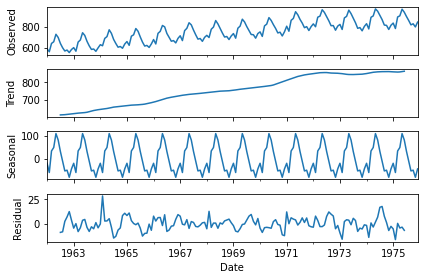

In [ ]:
results = seasonal_decompose(df['Production'])
results.plot();

In [ ]:
len(df)

168

In [ ]:
train = df.iloc[:156]
test = df.iloc[156:] # dejamos los ultimos 12 meses para test


https://stackoverflow.com/questions/62178888/can-someone-explain-to-me-how-minmaxscaler-works

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
df.head(),df.tail()

(            Production
 Date                  
 1962-01-01         589
 1962-02-01         561
 1962-03-01         640
 1962-04-01         656
 1962-05-01         727,             Production
 Date                  
 1975-08-01         858
 1975-09-01         817
 1975-10-01         827
 1975-11-01         797
 1975-12-01         843)


Para la normalización, esto significa que los datos de entrenamiento se utilizarán para estimar los valores mínimos y máximos observables. Esto se hace llamando a la función fit().

In [ ]:
scaler.fit(train) 
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [ ]:
scaled_train[:10]

array([[0.08653846],
       [0.01923077],
       [0.20913462],
       [0.24759615],
       [0.41826923],
       [0.34615385],
       [0.20913462],
       [0.11057692],
       [0.03605769],
       [0.05769231]])

vamos a formatear los datos exactamente para dárselos al nuevo modelo

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
# define generator

n_input = 3
n_features = 1 # va a ser uno, pero podrian ser mas si usamos multiples time series para hacer la prediccion
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

aqui vemos como el generator convierte la data. vemos comos los primeros 3 valores entran en un batch ( lote ) . Un tamaño de lote en general se refiere al número de ejemplos de entrenamiento utilizados por iteración

In [ ]:
# aca vemos como funciona el "generator"
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.08653846 0.01923077 0.20913462]
Predict this y: 
 [[0.24759615]]


In [ ]:
X.shape


(1, 3, 1)

In [ ]:
# antes tomabamos 3 meses, ahora tomamos 12
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [ ]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))  # 100 neuronas 
model.add(Dense(1)) #va a hacer la prediccion final 
model.compile(optimizer='adam', loss='mse') # complilamos el modelo usando el optimizador de adam y el mean square error como la funcion de perdida. 

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit model
model.fit(generator,epochs=50)

Epoch 1/50
144/144 [==============================] - 3s 8ms/step - loss: 0.0496
Epoch 2/50
144/144 [==============================] - 1s 7ms/step - loss: 0.0222
Epoch 3/50
144/144 [==============================] - 1s 7ms/step - loss: 0.0171
Epoch 4/50
144/144 [==============================] - 1s 7ms/step - loss: 0.0131
Epoch 5/50
144/144 [==============================] - 1s 7ms/step - loss: 0.0138
Epoch 6/50
144/144 [==============================] - 1s 8ms/step - loss: 0.0055
Epoch 7/50
144/144 [==============================] - 1s 7ms/step - loss: 0.0070
Epoch 8/50
144/144 [==============================] - 1s 6ms/step - loss: 0.0047
Epoch 9/50
144/144 [==============================] - 1s 10ms/step - loss: 0.0052
Epoch 10/50
144/144 [==============================] - 2s 15ms/step - loss: 0.0049
Epoch 11/50
144/144 [==============================] - 1s 8ms/step - loss: 0.0040
Epoch 12/50
144/144 [==============================] - 2s 12ms/step - loss: 0.0033
Epoch 13/50
144/144 [=

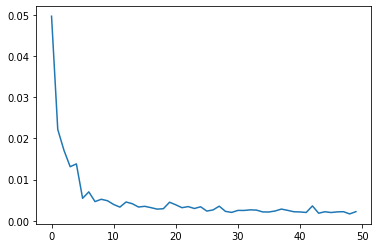

In [ ]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

# vemos lo q el modelo guarda por cada 

Uno de los problemas críticos al entrenar una red neuronal en los datos de muestra es el sobreajuste. 

In [ ]:
last_train_batch = scaled_train[-12:]

In [ ]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features)) 


In [ ]:
model.predict(last_train_batch)


array([[0.66882753]], dtype=float32)

In [ ]:
scaled_test[0]


array([0.67548077])

In [ ]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

# tomamos los ultimos 12 valores para hacer la prediccion
for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [ ]:
test_predictions

[array([0.66882753], dtype=float32),
 array([0.6424707], dtype=float32),
 array([0.8400233], dtype=float32),
 array([0.9152146], dtype=float32),
 array([1.0318282], dtype=float32),
 array([1.017379], dtype=float32),
 array([0.93803775], dtype=float32),
 array([0.8260785], dtype=float32),
 array([0.7055513], dtype=float32),
 array([0.6610541], dtype=float32),
 array([0.6083772], dtype=float32),
 array([0.65175825], dtype=float32)]

In [ ]:
test.head()


,Production
Date,
1975-01-01,834
1975-02-01,782
1975-03-01,892
1975-04-01,903
1975-05-01,966


In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)


In [ ]:
test['Predictions'] = true_predictions


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
true_predictions

array([[831.23225403],
       [820.26781845],
       [902.44968414],
       [933.72927284],
       [982.24051666],
       [976.22968292],
       [943.22370529],
       [896.6486454 ],
       [846.50935173],
       [827.9984951 ],
       [806.08492279],
       [824.13143349]])

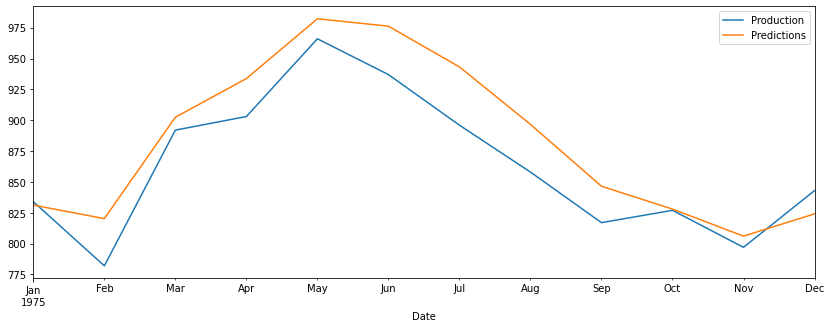

In [ ]:
test.plot(figsize=(14,5))


In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['Production'],test['Predictions']))
print(rmse)

27.93212971908119
